In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
from nltk.corpus import brown

torch.manual_seed(1)


In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Charger le fichier CSV contenant les données

data = pd.read_csv('/content/coarse-and-fine-grained-ner-dataset (1) (1).csv')

# Afficher les premières lignes pour vérifier la structure
print(data.head())




                                                Text  \
0   grandes feuilles opposées, oblongues-elliptiq...   
1   feuilles opposées, groupées à l'extrémité des...   
2   feuilles opposées, obovées oblongues, arrondi...   
3   arbustes  petites feuilles opposées, groupées...   
4   arbustes  feuilles opposées ou alternes, obla...   

                                      Organ Entities  \
0  ['bouton', 'pédicelle', 'corolle', 'tube', 'fe...   
1  ['limbe', 'style', 'filets', 'rameaux', 'sépal...   
2  ['corolle', 'limbe', 'ovaire', 'lobes', 'base'...   
3  ['anthères', 'pétales', 'tube', 'feuilles', 's...   
4  ['base', 'nervure', 'feuilles', 'arbustes', 'l...   

                                 Descriptor Entities  \
0  ['fermée', 'pubes-cents', 'cunéiformes', 'vent...   
1  ['elliptiques', '1 cm de longueur', 'extrorses...   
2  ['cunéiforme', '10,5 mm de longueur', 'long', ...   
3  ['secondaires', 'accusé', 'saillantes', 'apicu...   
4  ['proéminente', 'décurrente', 'alternes', '

In [12]:

# Préparer les phrases taguées pour le NER (en extrayant le texte et les entités associées)
tagged_sentences = []

for index, row in data.iterrows():
    text = row['Text']
    annotations = row['Fine-grained Annotation']

    # Convertir la chaîne d'annotations en une liste de tuples (start, end, label)
    annotations = eval(annotations)  # Utiliser eval pour convertir la chaîne en liste de tuples

    # Créer une liste des entités de la phrase sous forme de tuples (mot, étiquette)
    entities = [(text[start:end], label) for start, end, label in annotations]

    # Ajouter la phrase et les entités taguées à la liste
    tagged_sentences.append((text, entities))

# Afficher quelques exemples de données taguées
for i in range(5):
    print(f"Phrase {i+1}: {tagged_sentences[i]}")

# Fixer la graine pour la reproductibilité
torch.manual_seed(1)

Phrase 1: (" grandes feuilles opposées, oblongues-elliptiques ou obovées-elliptiques, arrondies au sommet, obtuses ou cunéiformes à la base  limbe glabre, mesurant jusqu'à 20 cm de longueur sur 12 cm de largeur  nervure médiane proéminente dessous, un peu saillante dessus  nervures secondaires, 5 à 10 paires, incurvées, réunies en arceaux assez loin de la marge, saillantes dessous, bien marquées dessus, anastomosées à un réseau de nervilles à grosses mailles irrégulières, finement saillant dessus  pétiole 5-20 mm  fleurs blanches fasciculées sur le vieux bois  pédicelle 4-6 mm, glabre ou légèrement pubescent  galice : 4 sépales (2 + 2) de 2,5 mm, un peu pubes-cents extérieurement  corolle à 8 lobes de 3 mm; tube 2 mm  ëtamines 8, insérées à la gorge; filets 3 mm  ovaire velu, à 4 loges, prolongé d'un long style glabre  dans le bouton la corolle, étroitement fermée, laisse poindre très apparemment le style  fruits inconnus  le spécimen type renferme une seule graine fusiforme non caréné

In [13]:
# Initialisation des listes X et Y
X = []
Y = []

# Parcours de chaque phrase taguée
for sentence in tagged_sentences:
    text = sentence[0]  # Le texte de la phrase
    entities = sentence[1]  # Les entités associées

    # Initialiser les listes pour chaque phrase
    X_sentence = []
    Y_sentence = []

    # Parcours des entités pour extraire les mots et les étiquettes
    for word, label in entities:
        X_sentence.append(word.lower())  # Ajouter le mot en minuscules
        Y_sentence.append(label)  # Ajouter l'étiquette correspondante

    # Ajouter la phrase et ses entités dans les listes X et Y
    X.append(X_sentence)
    Y.append(Y_sentence)

# Vérification des résultats
print(X[:2])  # Affiche les deux premières phrases (X)
print(Y[:2])  # Affiche les étiquettes des deux premières phrases (Y)


[['pubes-cents', 'anastomosées', 'sépales', 'bords', 'cicatrice', 'incurvées', 'secondaires', 'obovées-elliptiques', 'blanches', 'glabre', 'glabre', 'style', 'fleurs', 'bouton', 'fruits', '12 cm de largeur', 'fermée', 'feuilles', 'filets', 'pubescent', 'bois', 'marge', 'nervure', 'fasciculées', 'lobes', 'limbe', 'carénée', 'velu', 'crénelés', 'base', 'saillante', 'pédicelle', 'proéminente', 'ovaire', 'cunéiformes', 'corolle', 'graine', 'glabre', '20 cm de longueur', 'oblongues-elliptiques', 'nervilles', 'ventrale', 'tube', 'opposées', 'loges', 'style', 'réseau', 'corolle', 'insérées', 'pétiole', 'obtuses', 'fusiforme', 'laisse'], ['extrorses', 'obtuses', 'anthères', 'secondaires', 'glabre', 'saillante', 'style', 'base', '8 cm de longueur', 'insérées', 'glomérules', 'pétiole', 'glabre', 'pubescents', 'pétales', 'fruits', 'nervure', 'ovaire', '0,5 cm de diamètre', 'loges', 'lobes', 'pédicelles', 'ascendantes', 'tube', 'sépales', 'limbe', '1 cm de longueur', '3 cm de largeur', 'oblongues'

In [14]:
print("Total number of sentences: {}".format(len(X)))

Total number of sentences: 838


In [15]:
# Créer un vocabulaire à partir des mots (en minuscules)
vocab = set([word.lower() for sentence in X for word in sentence])

# Nombre de mots dans le vocabulaire
num_words = len(vocab)

print("Vocabulary size: {}".format(num_words))


Vocabulary size: 2737


In [16]:
# Créer un ensemble des tags uniques
tags = set([tag for sentence in Y for tag in sentence])

# Nombre total de tags
num_tags = len(tags)

print("Total number of tags: {}".format(num_tags))
print("Tags: ", tags)


Total number of tags: 10
Tags:  {'SURFACE', 'ORGANE', 'POSITION', 'FORME', 'COULEUR', 'DISPOSITION', 'STRUCTURE', 'DESCRIPTEUR', 'MESURE', 'DEVELOPPEMENT'}


In [17]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['pubes-cents', 'anastomosées', 'sépales', 'bords', 'cicatrice', 'incurvées', 'secondaires', 'obovées-elliptiques', 'blanches', 'glabre', 'glabre', 'style', 'fleurs', 'bouton', 'fruits', '12 cm de largeur', 'fermée', 'feuilles', 'filets', 'pubescent', 'bois', 'marge', 'nervure', 'fasciculées', 'lobes', 'limbe', 'carénée', 'velu', 'crénelés', 'base', 'saillante', 'pédicelle', 'proéminente', 'ovaire', 'cunéiformes', 'corolle', 'graine', 'glabre', '20 cm de longueur', 'oblongues-elliptiques', 'nervilles', 'ventrale', 'tube', 'opposées', 'loges', 'style', 'réseau', 'corolle', 'insérées', 'pétiole', 'obtuses', 'fusiforme', 'laisse'] 

sample Y:  ['DESCRIPTEUR', 'DISPOSITION', 'ORGANE', 'ORGANE', 'ORGANE', 'DESCRIPTEUR', 'POSITION', 'DESCRIPTEUR', 'COULEUR', 'SURFACE', 'SURFACE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'MESURE', 'DESCRIPTEUR', 'ORGANE', 'ORGANE', 'SURFACE', 'ORGANE', 'ORGANE', 'ORGANE', 'DISPOSITION', 'ORGANE', 'ORGANE', 'DESCRIPTEUR', 'SURFACE', 'STRUCTURE', 'ORG

In [18]:
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 53
Length of first output sequence : 53


In [19]:
word_to_ix = {}

# Remplir le dictionnaire word_to_ix avec un index unique pour chaque mot
for word in vocab:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)

# Afficher le dictionnaire résultant
print(word_to_ix)


{'5-60 mm de long': 0, '6-11 mm de diamètre': 1, 'arborescentes': 2, 'dressée-étalée': 3, 'glauques': 4, 'tronquée': 5, 'suture': 6, 'rangs': 7, 'grandes': 8, 'bullées': 9, 'feutrée': 10, 'ruminé': 11, 'adnés': 12, 'serrulés': 13, 'charnu-coriace': 14, 'sétuleux': 15, 'perpendiculaires': 16, 'longs': 17, 'pédoncules': 18, 'tridente': 19, 'staminifère': 20, 'réticulées': 21, 'digitées': 22, 'flabellées': 23, 'ombelles': 24, 'florifères': 25, 'écorce': 26, 'simple': 27, 'capillaire': 28, 'carénée': 29, 'caducs': 30, 'ailé': 31, '1,6 mm de diamètre': 32, '8 mm de longueur': 33, 'pluricaule': 34, 'apprimée': 35, 'denticulés': 36, 'grossiers': 37, 'papyracés': 38, 'hérissé': 39, '10-12 mm de diamètre': 40, 'allongés': 41, 'développé': 42, 'straminé': 43, 'cam': 44, 'bipennées': 45, '1,5-5 cm de longueur': 46, 'géminées': 47, 'muriquées': 48, 'arrondies': 49, 'pileux': 50, 'brun-vert': 51, 'glomérules': 52, 'vivace': 53, 'tubulaire': 54, 'monoïque': 55, 'ovales-lancéolés': 56, '3 cm de large

In [20]:
tag_to_ix = {}

for tag in tags:
  tag_to_ix[tag] = len(tag_to_ix)

print(tag_to_ix)


{'SURFACE': 0, 'ORGANE': 1, 'POSITION': 2, 'FORME': 3, 'COULEUR': 4, 'DISPOSITION': 5, 'STRUCTURE': 6, 'DESCRIPTEUR': 7, 'MESURE': 8, 'DEVELOPPEMENT': 9}


In [21]:
# Ajouter le token <PAD> avec un indice spécifique
PAD_TOKEN = "<PAD>"

# Ajouter le <PAD> dans les dictionnaires `word_to_ix` et `tag_to_ix`
word_to_ix[PAD_TOKEN] = len(word_to_ix)  # L'indice de <PAD> est défini comme le prochain indice disponible
tag_to_ix[PAD_TOKEN] = len(tag_to_ix)  # De même pour les tags

# Vérifier les dictionnaires pour s'assurer que <PAD> est bien ajouté
print(word_to_ix)
print(tag_to_ix)


{'5-60 mm de long': 0, '6-11 mm de diamètre': 1, 'arborescentes': 2, 'dressée-étalée': 3, 'glauques': 4, 'tronquée': 5, 'suture': 6, 'rangs': 7, 'grandes': 8, 'bullées': 9, 'feutrée': 10, 'ruminé': 11, 'adnés': 12, 'serrulés': 13, 'charnu-coriace': 14, 'sétuleux': 15, 'perpendiculaires': 16, 'longs': 17, 'pédoncules': 18, 'tridente': 19, 'staminifère': 20, 'réticulées': 21, 'digitées': 22, 'flabellées': 23, 'ombelles': 24, 'florifères': 25, 'écorce': 26, 'simple': 27, 'capillaire': 28, 'carénée': 29, 'caducs': 30, 'ailé': 31, '1,6 mm de diamètre': 32, '8 mm de longueur': 33, 'pluricaule': 34, 'apprimée': 35, 'denticulés': 36, 'grossiers': 37, 'papyracés': 38, 'hérissé': 39, '10-12 mm de diamètre': 40, 'allongés': 41, 'développé': 42, 'straminé': 43, 'cam': 44, 'bipennées': 45, '1,5-5 cm de longueur': 46, 'géminées': 47, 'muriquées': 48, 'arrondies': 49, 'pileux': 50, 'brun-vert': 51, 'glomérules': 52, 'vivace': 53, 'tubulaire': 54, 'monoïque': 55, 'ovales-lancéolés': 56, '3 cm de large

In [22]:
import torch
def prepare_sequence(sequence, word_to_ix):
    # Transformer une séquence de mots en indices à partir du dictionnaire `word_to_ix`
    return torch.tensor([word_to_ix[word] for word in sequence], dtype=torch.long)

def prepare_tag_sequence(tags, tag_to_ix):
    # Transformer une séquence de tags en indices
    return torch.tensor([tag_to_ix[tag] for tag in tags], dtype=torch.long)


In [23]:
from sklearn.model_selection import train_test_split

SPLIT_SIZE = 0.2

# Diviser l'ensemble complet de données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT_SIZE, random_state=4)

# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SPLIT_SIZE, random_state=4)

# Afficher le nombre d'exemples dans chaque ensemble
print("TRAINING DATA")
print('Number of sequences: {}'.format(len(X_train)))
print("-"*50)
print("TESTING DATA")
print('Number of sequences: {}'.format(len(X_test)))
print("-"*50)
print("VALIDATION DATA")
print('Number of sequences: {}'.format(len(X_val)))


TRAINING DATA
Number of sequences: 536
--------------------------------------------------
TESTING DATA
Number of sequences: 168
--------------------------------------------------
VALIDATION DATA
Number of sequences: 134


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # GATES - Weight matrices
        self.Wxi = nn.Linear(input_size, hidden_size)  # Input gate weights for input
        self.Whi = nn.Linear(hidden_size, hidden_size)  # Input gate weights for hidden state
        self.Wxf = nn.Linear(input_size, hidden_size)  # Forget gate weights for input
        self.Whf = nn.Linear(hidden_size, hidden_size)  # Forget gate weights for hidden state
        self.Wxo = nn.Linear(input_size, hidden_size)  # Output gate weights for input
        self.Who = nn.Linear(hidden_size, hidden_size)  # Output gate weights for hidden state
        self.Wxg = nn.Linear(input_size, hidden_size)  # Candidate gate weights for input
        self.Whg = nn.Linear(hidden_size, hidden_size)  # Candidate gate weights for hidden state

        # Biases for each gate
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        self.bc = nn.Parameter(torch.zeros(hidden_size))

        # Output layer
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, sentence):
        output = []
        device = sentence.device  # Récupère le dispositif des données (CPU ou GPU)
        h_t = torch.zeros(1, self.hidden_size, device=device)  # Initial hidden state
        c_t = torch.zeros(1, self.hidden_size, device=device)  # Initial cell state

        for x_t in sentence:
            # Input gate
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi)
            # Forget gate
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf)
            # Output gate
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo)
            # Candidate memory cell
            g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_t) + self.bc)

            # Update cell state
            c_t = f_t * c_t + i_t * g_t

            # Update hidden state
            h_t = o_t * torch.tanh(c_t)

            # Compute output
            out = self.h2o(h_t)
            output.append(out)

        output = torch.stack(output)
        return output, (h_t, c_t)

    def initHidden(self, device='cpu'):
        # Initialisation du hidden state pour un dispositif spécifique
        return torch.zeros(1, self.hidden_size, device=device)


In [25]:
class POSTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(POSTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(embedding_dim, hidden_dim, hidden_dim)  # Utilisation de votre LSTM personnalisé
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)  # La sortie de LSTM est de forme (seq_len, batch_size, hidden_dim)

        # Redimensionner la sortie de LSTM pour être compatible avec hidden2tag
        lstm_out = lstm_out.view(-1, self.hidden_dim)  # Redimensionner en (batch_size * seq_len, hidden_dim)

        tag_scores = self.hidden2tag(lstm_out)  # Appliquer la couche linéaire

        return tag_scores


In [26]:
import torch.optim as optim

# Hyperparamètres
EMBEDDING_DIM = 256
HIDDEN_DIM = 200
EPOCHS =50
LEARNING_RATE = 0.001


In [27]:
# Initialisation du modèle
num_words = len(word_to_ix)  # Taille du vocabulaire
num_tags = len(tag_to_ix)  # Nombre de tags POS
model = POSTagger(EMBEDDING_DIM, HIDDEN_DIM, num_words, num_tags)



In [28]:

# Fonction de perte et Optimiseur
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [29]:
# Détection automatique du dispositif (GPU ou CPU)
device = torch.device('cpu')

print(f"Using device: {device}")

# Préparer le modèle sur le dispositif détecté
model = POSTagger(EMBEDDING_DIM, HIDDEN_DIM, num_words, num_tags).to(device)

# Tester les scores avant l'entraînement
with torch.no_grad():
    # Préparer la première phrase du jeu d'entraînement sur le bon dispositif
    inputs = prepare_sequence(X_train[0], word_to_ix).to(device)

    # Obtenir les scores des tags
    tag_scores = model(inputs)

    print("Tag scores before training:")
    print(tag_scores)



Using device: cpu
Tag scores before training:
tensor([[ 0.1074,  0.0492, -0.0129, -0.0103, -0.1444, -0.0512, -0.0734, -0.0123,
         -0.1241,  0.0120, -0.0635],
        [ 0.0203,  0.0348,  0.0391, -0.0438, -0.0926,  0.0094, -0.0821, -0.0405,
         -0.0988,  0.0146, -0.0591],
        [ 0.0865,  0.0504, -0.0594, -0.0087, -0.1105,  0.0157, -0.1111, -0.0482,
         -0.0865,  0.0226, -0.0906],
        [ 0.1224,  0.0662, -0.0654, -0.0682, -0.0975,  0.0433, -0.0858, -0.0445,
         -0.0411, -0.0277, -0.0654],
        [ 0.0694,  0.0148, -0.0204, -0.0830, -0.1076, -0.0100, -0.0192, -0.0595,
         -0.0758, -0.0116, -0.0743],
        [ 0.0829, -0.0224, -0.0118, -0.0294, -0.1611,  0.0056, -0.0478,  0.0015,
         -0.0857, -0.0925, -0.0338],
        [ 0.0813,  0.0596,  0.0005, -0.0810, -0.0637, -0.0833, -0.0854,  0.0144,
         -0.0660, -0.0569, -0.0221],
        [ 0.0380,  0.0287,  0.0770, -0.0375, -0.0900, -0.1147, -0.1143,  0.0087,
         -0.0078, -0.0427, -0.1008],
        [ 

In [30]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# Convertir X_train et Y_train en indices avec prepare_sequence
X_train_indices = [prepare_sequence(sentence, word_to_ix) for sentence in X_train]
Y_train_indices = [prepare_tag_sequence(tags, tag_to_ix) for tags in Y_train]

X_val_indices = [prepare_sequence(sentence, word_to_ix) for sentence in X_val]
Y_val_indices = [prepare_tag_sequence(tags, tag_to_ix) for tags in Y_val]

# Convertir les listes en tenseurs en les remplissant (padding)
X_train_tensor = torch.nn.utils.rnn.pad_sequence(X_train_indices, batch_first=True, padding_value=word_to_ix[PAD_TOKEN])
Y_train_tensor = torch.nn.utils.rnn.pad_sequence(Y_train_indices, batch_first=True, padding_value=tag_to_ix[PAD_TOKEN])

X_val_tensor = torch.nn.utils.rnn.pad_sequence(X_val_indices, batch_first=True, padding_value=word_to_ix[PAD_TOKEN])
Y_val_tensor = torch.nn.utils.rnn.pad_sequence(Y_val_indices, batch_first=True, padding_value=tag_to_ix[PAD_TOKEN])

# Créer des DataLoader pour le traitement par lots
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Initialisation des listes pour stocker les pertes
losses_train, losses_val = [], []

# Optimiseur Adam et fonction de perte avec ignore_index pour les tokens de padding
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss(ignore_index=tag_to_ix[PAD_TOKEN])

# Progress bar
bar = tqdm(range(EPOCHS))

for epoch in bar:
    mean_loss_train, mean_loss_val = 0, 0

    # Entraînement du modèle sur le jeu d'entraînement
    model.train()  # Définir le modèle en mode entraînement
    for sentence, tags in train_loader:  # Cette boucle doit être dans la boucle d'époques
        model.zero_grad()

        sentence_in = sentence.to(device)
        targets = tags.to(device)

        # Exécution du passage avant (forward pass) avec LSTM
        output = model(sentence_in)

        # Vérification du type et de la longueur de la sortie
        if isinstance(output, tuple):
            print(f"Output is a tuple with {len(output)} elements.")
        else:
            print(f"Output is a single tensor with shape: {output.shape}")

        # Si c'est un tuple (score, (h_t, c_t)), vous pouvez déballer
        if len(output) == 2:
            tag_scores, (h_t, c_t) = output
        else:
            tag_scores = output

        # Calcul de la perte
        loss = loss_function(tag_scores.view(-1, num_tags), targets.view(-1))
        mean_loss_train += loss.item()

        # Rétropropagation des gradients
        loss.backward()
        optimizer.step()

    losses_train.append(mean_loss_train / len(train_loader))

    # Validation sur le jeu de validation
    model.eval()  # Définir le modèle en mode évaluation
    mean_loss_val = 0  # Réinitialiser la perte de validation pour cette époque
    with torch.no_grad():  # Pas de rétropropagation pendant la validation
        for sentence, tags in val_loader:
            sentence_in = sentence.to(device)
            targets = tags.to(device)

            # Exécution du passage avant sans tenter de récupérer l'état caché
            tag_scores = model(sentence_in)

            # Calcul de la perte pour la validation
            loss = loss_function(tag_scores.view(-1, num_tags), targets.view(-1))
            mean_loss_val += loss.item()

    losses_val.append(mean_loss_val / len(val_loader))

    # Affichage de la progression de l'entraînement et de la validation
    bar.set_description(f"Train Loss: {losses_train[-1]:.4f} | Val Loss: {losses_val[-1]:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 1.7084 | Val Loss: 1.3082:   2%|▏         | 1/50 [00:07<06:05,  7.45s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 1.0913 | Val Loss: 0.9051:   4%|▍         | 2/50 [00:13<05:17,  6.61s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.7198 | Val Loss: 0.6062:   6%|▌         | 3/50 [00:20<05:28,  6.99s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.4767 | Val Loss: 0.4234:   8%|▊         | 4/50 [00:26<05:02,  6.58s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.3211 | Val Loss: 0.3068:  10%|█         | 5/50 [00:34<05:06,  6.82s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.2244 | Val Loss: 0.2348:  12%|█▏        | 6/50 [00:39<04:45,  6.49s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.1589 | Val Loss: 0.1866:  14%|█▍        | 7/50 [00:47<04:52,  6.79s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.1159 | Val Loss: 0.1585:  16%|█▌        | 8/50 [00:53<04:32,  6.49s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0865 | Val Loss: 0.1389:  18%|█▊        | 9/50 [01:00<04:35,  6.72s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0636 | Val Loss: 0.1262:  20%|██        | 10/50 [01:06<04:18,  6.45s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0484 | Val Loss: 0.1176:  22%|██▏       | 11/50 [01:13<04:20,  6.67s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0377 | Val Loss: 0.1130:  24%|██▍       | 12/50 [01:19<04:04,  6.44s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0273 | Val Loss: 0.1111:  26%|██▌       | 13/50 [01:26<04:08,  6.72s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0201 | Val Loss: 0.1106:  28%|██▊       | 14/50 [01:32<03:53,  6.49s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0154 | Val Loss: 0.1111:  30%|███       | 15/50 [01:39<03:54,  6.69s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0111 | Val Loss: 0.1135:  32%|███▏      | 16/50 [01:45<03:40,  6.47s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0086 | Val Loss: 0.1151:  34%|███▍      | 17/50 [01:52<03:35,  6.54s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0066 | Val Loss: 0.1172:  36%|███▌      | 18/50 [01:58<03:26,  6.46s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0050 | Val Loss: 0.1197:  38%|███▊      | 19/50 [02:05<03:19,  6.44s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0040 | Val Loss: 0.1225:  40%|████      | 20/50 [02:14<03:36,  7.21s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0036 | Val Loss: 0.1243:  42%|████▏     | 21/50 [02:21<03:27,  7.17s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0027 | Val Loss: 0.1266:  44%|████▍     | 22/50 [02:27<03:12,  6.88s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0025 | Val Loss: 0.1283:  46%|████▌     | 23/50 [02:34<03:04,  6.82s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0024 | Val Loss: 0.1304:  48%|████▊     | 24/50 [02:40<02:55,  6.73s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0020 | Val Loss: 0.1320:  50%|█████     | 25/50 [02:46<02:45,  6.61s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0019 | Val Loss: 0.1342:  52%|█████▏    | 26/50 [02:53<02:40,  6.70s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0017 | Val Loss: 0.1362:  54%|█████▍    | 27/50 [02:59<02:28,  6.46s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0013 | Val Loss: 0.1380:  56%|█████▌    | 28/50 [03:07<02:27,  6.70s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0012 | Val Loss: 0.1390:  58%|█████▊    | 29/50 [03:12<02:15,  6.46s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0011 | Val Loss: 0.1410:  60%|██████    | 30/50 [03:20<02:14,  6.74s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0011 | Val Loss: 0.1424:  62%|██████▏   | 31/50 [03:26<02:05,  6.61s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0009 | Val Loss: 0.1439:  64%|██████▍   | 32/50 [03:33<02:02,  6.80s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0009 | Val Loss: 0.1455:  66%|██████▌   | 33/50 [03:39<01:50,  6.53s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0007 | Val Loss: 0.1463:  68%|██████▊   | 34/50 [03:47<01:48,  6.76s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0010 | Val Loss: 0.1476:  70%|███████   | 35/50 [03:52<01:37,  6.50s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0007 | Val Loss: 0.1486:  72%|███████▏  | 36/50 [04:00<01:34,  6.74s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0006 | Val Loss: 0.1497:  74%|███████▍  | 37/50 [04:06<01:24,  6.48s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0005 | Val Loss: 0.1508:  76%|███████▌  | 38/50 [04:13<01:20,  6.75s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0006 | Val Loss: 0.1518:  78%|███████▊  | 39/50 [04:19<01:11,  6.50s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0005 | Val Loss: 0.1527:  80%|████████  | 40/50 [04:26<01:06,  6.69s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0005 | Val Loss: 0.1537:  82%|████████▏ | 41/50 [04:32<00:58,  6.53s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0004 | Val Loss: 0.1542:  84%|████████▍ | 42/50 [04:39<00:52,  6.57s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0005 | Val Loss: 0.1552:  86%|████████▌ | 43/50 [04:46<00:46,  6.60s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0004 | Val Loss: 0.1559:  88%|████████▊ | 44/50 [04:52<00:38,  6.50s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0004 | Val Loss: 0.1566:  90%|█████████ | 45/50 [04:59<00:33,  6.68s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0004 | Val Loss: 0.1574:  92%|█████████▏| 46/50 [05:05<00:25,  6.45s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0003 | Val Loss: 0.1583:  94%|█████████▍| 47/50 [05:12<00:20,  6.67s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0003 | Val Loss: 0.1591:  96%|█████████▌| 48/50 [05:18<00:12,  6.45s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0003 | Val Loss: 0.1599:  98%|█████████▊| 49/50 [05:25<00:06,  6.74s/it]

Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tensor with shape: torch.Size([5024, 11])
Output is a single tenso

Train Loss: 0.0004 | Val Loss: 0.1606: 100%|██████████| 50/50 [05:31<00:00,  6.64s/it]


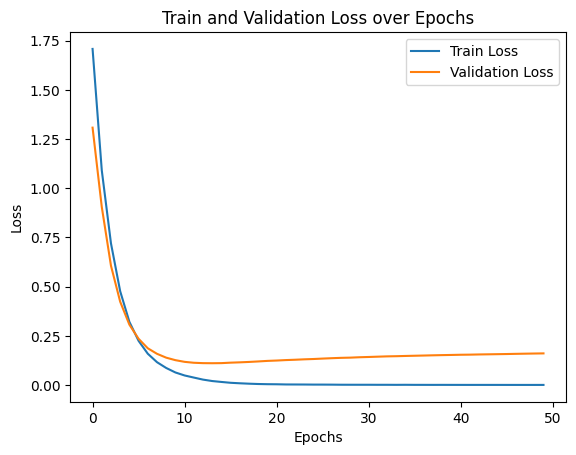

In [31]:
import matplotlib.pyplot as plt

# Affichage des courbes de perte d'entraînement et de validation
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_val, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss over Epochs')
plt.show()


In [33]:

import torch

# Fonction pour tester une phrase donnée et afficher les prédictions de tags
def test_sentence(sentence, model, word_to_ix, tag_to_ix, device):
    # Préparer la séquence de mots et les tags de la phrase d'entrée
    sentence_in = prepare_sequence(sentence, word_to_ix).to(device)

    # Passer la phrase dans le modèle pour obtenir les scores de tags
    with torch.no_grad():  # Pas de rétropropagation, on est en mode évaluation
        tag_scores = model(sentence_in)

    # Convertir les scores en prédictions de tags (index des scores les plus élevés)
    _, predicted_tags = torch.max(tag_scores, dim=1)

    # Convertir les indices de prédictions en tags réels
    predicted_tags = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag.item())] for tag in predicted_tags]

    return predicted_tags

# Exemple d'une phrase de votre jeu d'entraînement (remplacez par une phrase spécifique)
sentence = X_train[0]  # Utilisez la première phrase du jeu d'entraînement

# Obtenir les prédictions pour cette phrase
predicted_tags = test_sentence(sentence, model, word_to_ix, tag_to_ix, device)

# Afficher la phrase et les tags prédits
print("Sentence:")
print(sentence)
print("\nPredicted Tags:")
print(predicted_tags)


Sentence:
['courts', 'ferrugineux', 'réticulées', 'calice', 'feuilles', 'nervures', 'corolle', 'écorce', 'rameaux', 'nervilles', 'décurrente', 'fructifère', 'corolle', 'calice', 'arbuste', 'coriaces', 'oblancéolé', 'pubérulents', 'feuilles', 'glabre', 'réfléchis', 'voyants', 'court', 'feuilles', 'petit', 'rameaux', 'marge', 'fructifère', 'feuilles', 'poils', 'corolle', 'limbe', 'fleurs', 'calice', 'bouton', 'persistants', 'poils', 'cunéiforme', 'cupuliforme', 'visibles', 'arbre', 'base', 'fruit', 'feuilles', 'tube', 'fructifère', 'rameaux', 'pétiole', 'émarginé', 'nervures', 'bords', 'calice', 'pédicelles', 'fleurs', 'feuilles', 'calice', 'jaune', 'fructifère', 'calice', 'petit', 'grossiers', 'révolutée', 'lobes', 'lobes', 'fruit', 'fascicules', 'ellipsoïde', 'large', 'ondulée', 'axillaires', 'lobé', 'aisselle', 'fruit', 'lobé', 'obtus', 'fruit']

Predicted Tags:
['DESCRIPTEUR', 'COULEUR', 'SURFACE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'DISPOSITION', '

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PeepholeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PeepholeLSTM, self).__init__()

        self.hidden_size = hidden_size

        # GATES - Weight matrices
        self.Wxi = nn.Linear(input_size, hidden_size)  # Input gate weights for input
        self.Whi = nn.Linear(hidden_size, hidden_size)  # Input gate weights for hidden state
        self.Wxf = nn.Linear(input_size, hidden_size)  # Forget gate weights for input
        self.Whf = nn.Linear(hidden_size, hidden_size)  # Forget gate weights for hidden state
        self.Wxo = nn.Linear(input_size, hidden_size)  # Output gate weights for input
        self.Who = nn.Linear(hidden_size, hidden_size)  # Output gate weights for hidden state
        self.Wxg = nn.Linear(input_size, hidden_size)  # Candidate gate weights for input
        self.Whg = nn.Linear(hidden_size, hidden_size)  # Candidate gate weights for hidden state

        # Peephole connections - weights for cell state contributions to gates
        self.W_i_cell = nn.Parameter(torch.zeros(hidden_size))  # Peephole connection for input gate
        self.W_f_cell = nn.Parameter(torch.zeros(hidden_size))  # Peephole connection for forget gate
        self.W_o_cell = nn.Parameter(torch.zeros(hidden_size))  # Peephole connection for output gate

        # Biases for each gate
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        self.bc = nn.Parameter(torch.zeros(hidden_size))

        # Output layer
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, sentence):
        output = []
        device = sentence.device  # Récupère le dispositif des données (CPU ou GPU)
        h_t = torch.zeros(1, self.hidden_size, device=device)  # Initial hidden state
        c_t = torch.zeros(1, self.hidden_size, device=device)  # Initial cell state

        for x_t in sentence:
            # Input gate (with peephole connection)
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi + self.W_i_cell * c_t)
            # Forget gate (with peephole connection)
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf + self.W_f_cell * c_t)
            # Output gate (with peephole connection)
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo + self.W_o_cell * c_t)
            # Candidate memory cell
            g_t = torch.tanh(self.Wxg(x_t) + self.Whg(h_t) + self.bc)

            # Update cell state
            c_t = f_t * c_t + i_t * g_t

            # Update hidden state
            h_t = o_t * torch.tanh(c_t)

            # Compute output
            out = self.h2o(h_t)
            output.append(out)

        output = torch.stack(output)
        return output, (h_t, c_t)

    def initHidden(self, device='cpu'):
        # Initialisation du hidden state pour un dispositif spécifique
        return torch.zeros(1, self.hidden_size, device=device)


In [53]:
class POSTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(POSTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Passez output_size comme argument de PeepholeLSTM
        self.lstm = PeepholeLSTM(embedding_dim, hidden_dim, hidden_dim)  # hidden_dim comme output_size ici
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)  # Passer les embeddings à PeepholeLSTM
        tag_scores = self.hidden2tag(lstm_out)
        return tag_scores


In [41]:
embedding_dim = 128
hidden_dim = 256
output_size = 10  # Nombre de classes ou de sorties
vocab_size = 2737  # Taille du vocabulaire (ajustez en fonction de votre jeu de données)

# Initialiser le modèle
model = PeepholeLSTM(input_size=embedding_dim, hidden_size=hidden_dim, output_size=output_size).to(device)


In [50]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fonction d'entraînement
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    best_val_accuracy = 0.0
    train_accuracies = []  # Pour stocker les accuracies d'entraînement
    val_accuracies = []    # Pour stocker les accuracies de validation

    for epoch in range(num_epochs):
        model.train()  # Mode entraînement
        total_loss = 0.0
        all_train_predictions = []
        all_train_labels = []

        for sentences, labels in train_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Réinitialiser les gradients

            # Forward pass
            tag_scores = model(sentences)
            tag_scores = tag_scores.view(-1, tag_scores.size(-1))  # Redimensionner pour correspondre à labels
            labels = labels.view(-1)  # Redimensionner les étiquettes

            # Calcul de la perte
            loss = criterion(tag_scores, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Mise à jour des poids

            total_loss += loss.item()

            # Calcul des prédictions et ajouter à la liste
            _, predicted_tags = torch.max(tag_scores, dim=-1)
            all_train_predictions.extend(predicted_tags.cpu().numpy().flatten())
            all_train_labels.extend(labels.cpu().numpy().flatten())

        # Calcul de l'accuracy de l'entraînement
        train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
        train_accuracies.append(train_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")

        # Validation après chaque époque
        val_accuracy = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%")

        # Sauvegarde du meilleur modèle
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_peehole_lstm_model.pth")

    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

    # Retourner les résultats pour les analyser après l'entraînement
    return train_accuracies, val_accuracies


In [51]:
# Fonction pour évaluer le modèle
def evaluate_model(model, data_loader, device):
    model.eval()  # Mode évaluation
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sentences, labels in data_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            # Forward pass
            tag_scores = model(sentences)
            _, predicted_tags = torch.max(tag_scores, dim=-1)

            all_predictions.extend(predicted_tags.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calcul des métriques
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)

    # Affichage des résultats
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Retourner l'accuracy pour l'utilisation dans le calcul
    return accuracy * 100


In [63]:
# Hyperparamètres
embedding_dim = 128
hidden_dim = 256
vocab_size = len(word_to_ix)  # La taille du vocabulaire
tagset_size = len(tag_to_ix) # Nombre d'étiquettes (ajustez selon votre tâche)
num_epochs = 50
learning_rate = 0.001

# Modèle, critère et optimiseur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = POSTagger(embedding_dim, hidden_dim, vocab_size, tagset_size).to(device)

# Optimiseur et fonction de perte
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignorer le padding (index 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement et récupération des résultats
train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)




Epoch [1/50], Loss: 17.1370, Train Accuracy: 69.54%
Accuracy: 82.76%
Precision: 0.79
Recall: 0.83
F1 Score: 0.77
Epoch [1/50], Validation Accuracy: 82.76%
Epoch [2/50], Loss: 8.1018, Train Accuracy: 85.65%
Accuracy: 83.51%
Precision: 0.85
Recall: 0.84
F1 Score: 0.79
Epoch [2/50], Validation Accuracy: 83.51%
Epoch [3/50], Loss: 6.2755, Train Accuracy: 86.07%
Accuracy: 84.27%
Precision: 0.85
Recall: 0.84
F1 Score: 0.80
Epoch [3/50], Validation Accuracy: 84.27%
Epoch [4/50], Loss: 5.3102, Train Accuracy: 87.92%
Accuracy: 87.58%
Precision: 0.88
Recall: 0.88
F1 Score: 0.85
Epoch [4/50], Validation Accuracy: 87.58%
Epoch [5/50], Loss: 4.3294, Train Accuracy: 90.18%
Accuracy: 89.80%
Precision: 0.89
Recall: 0.90
F1 Score: 0.88
Epoch [5/50], Validation Accuracy: 89.80%
Epoch [6/50], Loss: 3.4265, Train Accuracy: 92.06%
Accuracy: 91.47%
Precision: 0.93
Recall: 0.91
F1 Score: 0.90
Epoch [6/50], Validation Accuracy: 91.47%
Epoch [7/50], Loss: 2.7606, Train Accuracy: 93.23%
Accuracy: 92.51%
Precisi

In [59]:
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Fonction pour tester l'accuracy sur les données de validation ou de test
def test_accuracy(model, data_loader, device):
    model.eval()  # Passer le modèle en mode évaluation
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Pas de calcul de gradients pendant l'évaluation
        for sentence, tags in data_loader:
            sentence_in = sentence.to(device)
            targets = tags.to(device)

            # Faire la prédiction
            tag_scores = model(sentence_in)

            if tag_scores.dim() == 3:  # Si la sortie est de dimension 3 (batch_size, seq_len, num_tags)
                _, predicted_tags = torch.max(tag_scores, dim=2)
            # Si les scores sont sous forme (batch_size, seq_len), ce n'est pas nécessaire
            else:
                predicted_tags = tag_scores.argmax(dim=1)

            # Ajouter les prédictions et les étiquettes réelles pour calculer l'accuracy
            all_predictions.extend(predicted_tags.cpu().numpy().flatten())
            all_labels.extend(targets.cpu().numpy().flatten())

    # Calculer l'accuracy (ignorer le padding)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Retourner les métriques classiques
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

# Appeler la fonction pour calculer l'accuracy
test_accuracy_value, precision_value, recall_value, f1_value = test_accuracy(model, val_loader, device)  # Ou test_loader si vous avez un jeu de test
print(f'Test Accuracy: {test_accuracy_value * 100:.2f}%')
print(f'Precision: {precision_value:.2f}')
print(f'Recall: {recall_value:.2f}')
print(f'F1 Score: {f1_value:.2f}')



Test Accuracy: 97.16%
Precision: 0.97
Recall: 0.97
F1 Score: 0.96


In [62]:
import torch

# Fonction pour préparer la séquence en indices à partir de word_to_ix
def prepare_sequence(sequence, word_to_ix):
    return torch.tensor([word_to_ix.get(word, word_to_ix["<UNK>"]) for word in sequence], dtype=torch.long)

# Fonction pour tester une phrase donnée et afficher les prédictions de tags
def test_sentence(sentence, model, word_to_ix, tag_to_ix, device):
    # Préparer la séquence de mots
    sentence_in = prepare_sequence(sentence, word_to_ix).unsqueeze(0).to(device)  # Ajouter une dimension pour le batch

    # Passer la phrase dans le modèle pour obtenir les scores de tags
    with torch.no_grad():  # Pas de rétropropagation, on est en mode évaluation
        tag_scores = model(sentence_in)

    # Convertir les scores en prédictions de tags (index des scores les plus élevés)
    _, predicted_tags = torch.max(tag_scores, dim=2)  # Dim 2 car c'est une séquence

    # Convertir les indices de prédictions en tags réels
    predicted_tags = predicted_tags.squeeze().cpu().numpy()  # Convertir à numpy pour faciliter l'accès
    predicted_tags = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(tag)] for tag in predicted_tags]

    return predicted_tags

# Exemple d'une phrase de votre jeu d'entraînement (remplacez par une phrase spécifique)
sentence = X_train[0]  # Utilisez la première phrase du jeu d'entraînement

# Obtenir les prédictions pour cette phrase
predicted_tags = test_sentence(sentence, model, word_to_ix, tag_to_ix, device)

# Afficher la phrase et les tags prédits
print("Sentence:")
print(sentence)
print("\nPredicted Tags:")
print(predicted_tags)


Sentence:
['courts', 'ferrugineux', 'réticulées', 'calice', 'feuilles', 'nervures', 'corolle', 'écorce', 'rameaux', 'nervilles', 'décurrente', 'fructifère', 'corolle', 'calice', 'arbuste', 'coriaces', 'oblancéolé', 'pubérulents', 'feuilles', 'glabre', 'réfléchis', 'voyants', 'court', 'feuilles', 'petit', 'rameaux', 'marge', 'fructifère', 'feuilles', 'poils', 'corolle', 'limbe', 'fleurs', 'calice', 'bouton', 'persistants', 'poils', 'cunéiforme', 'cupuliforme', 'visibles', 'arbre', 'base', 'fruit', 'feuilles', 'tube', 'fructifère', 'rameaux', 'pétiole', 'émarginé', 'nervures', 'bords', 'calice', 'pédicelles', 'fleurs', 'feuilles', 'calice', 'jaune', 'fructifère', 'calice', 'petit', 'grossiers', 'révolutée', 'lobes', 'lobes', 'fruit', 'fascicules', 'ellipsoïde', 'large', 'ondulée', 'axillaires', 'lobé', 'aisselle', 'fruit', 'lobé', 'obtus', 'fruit']

Predicted Tags:
['DESCRIPTEUR', 'COULEUR', 'DESCRIPTEUR', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'ORGANE', 'DISPOSITION